<a href="https://colab.research.google.com/github/acastellanos-ie/machine_learning_2/blob/master/pca_lda_practice/practice_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [1]:
repository_url = 'https://github.com/acastellanos-ie/machine_learning_2'

In [2]:
! git clone $repository_url

Cloning into 'machine_learning_2'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 372 (delta 207), reused 101 (delta 32), pack-reused 0
Receiving objects: 100% (372/372), 48.22 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (207/207), done.


Install the requirements

In [3]:
! pip install -Uqqr machine_learning_2/requirements.txt

     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 10.3 MB 11.9 MB/s 
     |████████████████████████████████| 15.7 MB 60 kB/s 
     |████████████████████████████████| 11.3 MB 21.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |████████████████████████████████| 261 kB 59.1 MB/s 
     |████████████████████████████████| 62 kB 714 kB/s 
     |████████████████████████████████| 23.9 MB 14 kB/s 
     |████████████████████████████████| 173.5 MB 45 kB/s 
     |████████████████████████████████| 10.1 MB 23.3 MB/s 
     |████████████████████████████████| 675 kB 46.6 MB/s 
     |████████████████████████████████| 3.1 MB 19.5 MB/s 
     |████████████████████████████████| 62 kB 830 kB/s 
     |████████████████████████████████| 102 kB 11.6 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 303 kB 60.8 MB/s 
     |████████████████████████████████| 812 kB 59.9 MB/s 
     |█████████████

Go to the practice directory



In [1]:
%cd machine_learning_2/pca_lda_practice

/content/machine_learning_2/pca_lda_practice


Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

The following code includes some imports and configuration steps for better visualization

In [3]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score

# Introduction

For this practice we are going to use the Breast Cancer Wisconsin data set from the [*UCI Machine learning repo*](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) and try to detect whether a breast cancer cell is benign or malignant.

The dataset includes  569 observations and 32 variables measuring the size and shape of cell nuclei. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image.

In more detail, the diagnosis, a categorical variable, is our response variable and the 30 measurement variables, all of which are continuous, are our potential explanatory variables for our model.
These 30 measurement variables are actually only 10 different features of the nucleus, but with 3 different measurements of each: mean, standard error and the ‘worst’ or largest (mean of the three largest values).

The features included are:

* **radius** - mean of distances from center to points on the perimeter
* **texture** - standard deviation of gray-scale values
* **perimeter**
* **area**
* **smoothness** - local variation in radius lengths
* **compactness** - perimeter^2 / area - 1.0
* **concavity** - severity of concave portions of the contour
* **concave points** - number of concave portions of the contour
* **symmetry** 
* **fractal dimension** - "coastline approximation" - 1

# Data Loading

We load the dataset from the CSV file

In [5]:
original_dataset = pd.read_csv("./data/data.csv") # We keep the original dataset for comparison
dataset = original_dataset

dataset.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


As we discussed in class, you need to standardize the data since before applying PCA. PCA's output is influenced based on the scale of the features of the data.

To apply normalization, you will import the `StandardScaler` module from the sklearn library and then apply scaling by doing `fit_transform` on the feature data.

While applying `StandardScaler`, each feature of your data should be normally distributed such that it will scale the distribution to a mean of zero and a standard deviation of one.

In [6]:
from sklearn.preprocessing import StandardScaler

X = dataset.iloc[:,2:32].values # We do not take the class label
dataset.iloc[:,2:32] = StandardScaler().fit_transform(X) # normalizing the features

dataset.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,NaN
1,842517,M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,NaN
2,84300903,M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,NaN
3,84348301,M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,NaN
4,84358402,M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,NaN


# Principal Components Analysis

*Why PCA?*

We will try to reduce the dimensionality of the dataset by applying PCA. There are thirty variables that can be combined using PCA into different linear combinations that each explain a part of the variance of the model.

If we take a look to the correlation matrix, we can see that there are large correlations between some variables (i.e., we expected that behavior since we have 3 different measures for the same phenomena). Since PCA relies in these correlations, it is reasonable to expect that it is going to be able to find a better representation of the data.

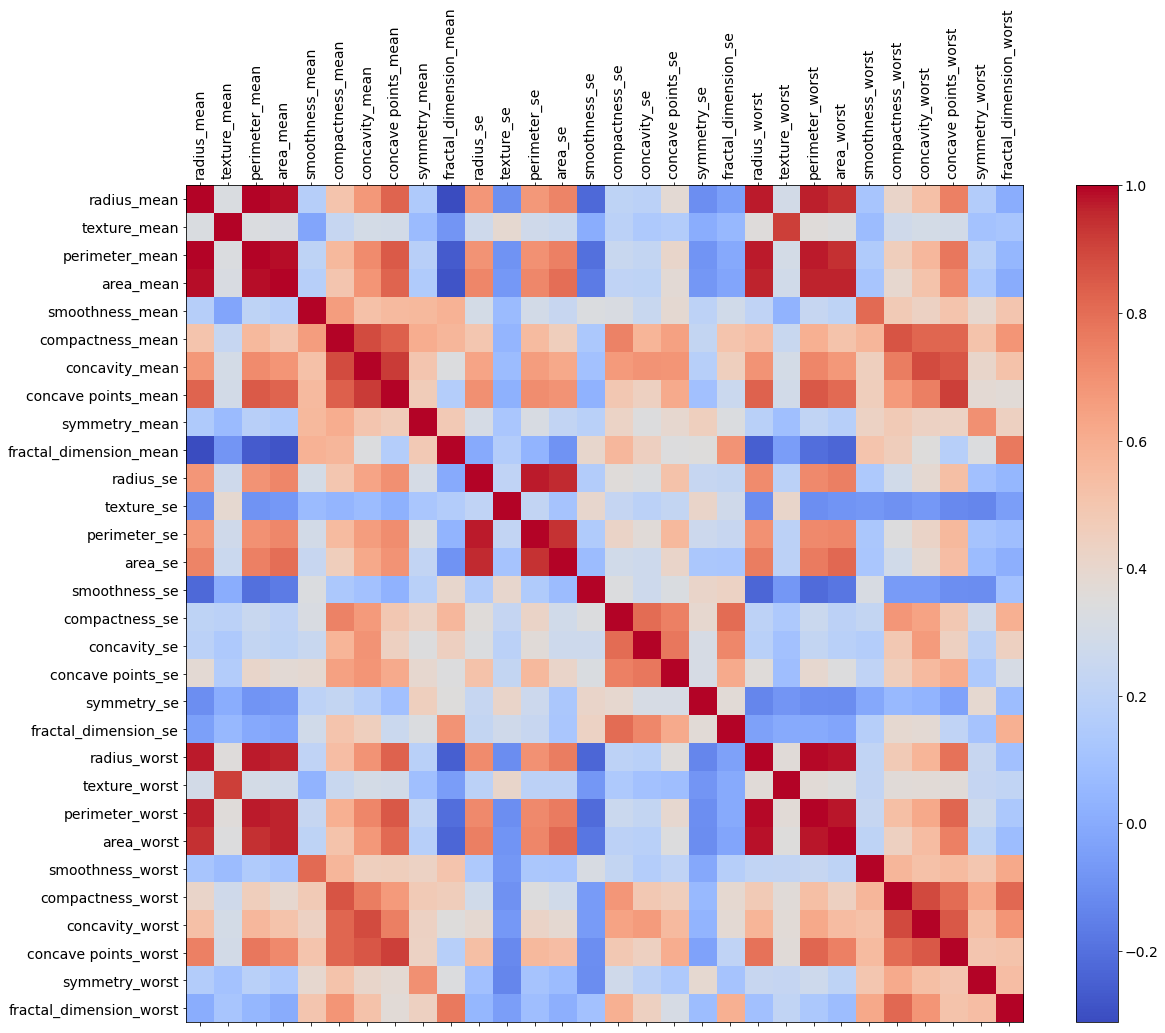

In [7]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.iloc[:,2:32].corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(dataset.iloc[:,2:32].shape[1]), dataset.iloc[:,2:32].columns, fontsize=14, rotation=90)
plt.yticks(range(dataset.iloc[:,2:32].shape[1]), dataset.iloc[:,2:32].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

As the correlation matrix shows some correlations between the features, let's compute the Principal Components of the dataset 

In [8]:
from sklearn.decomposition import PCA

pca_breast = PCA()

principalComponents_breast = pca_breast.fit_transform(dataset.iloc[:,2:32])

pd.DataFrame(principalComponents_breast).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,2.029230e-17,-9.151047e-17,-5.424288e-17,-2.107277e-17,4.877957e-17,-2.107277e-17,-7.804731e-18,-2.653609e-17,-2.702388e-17,-3.976754e-17,8.633984e-18,1.317048e-18,2.126789e-17,3.980413e-17,-9.658355e-18,-3.453594e-17,3.365790e-17,-3.404814e-17,-1.819478e-17,8.487645e-18,3.121893e-18,2.526782e-17,1.267049e-17,1.209733e-17,1.968865e-17,-3.463350e-17,1.024371e-17,-9.701037e-18,-8.499840e-18,-7.408397e-18
std,3.647601e+00,2.387755e+00,1.680152e+00,1.408591e+00,1.285159e+00,1.099765e+00,8.224408e-01,6.909821e-01,6.462420e-01,5.927148e-01,5.426169e-01,5.114892e-01,4.917138e-01,3.965932e-01,3.070842e-01,2.828487e-01,2.439336e-01,2.295897e-01,2.226313e-01,1.766756e-01,1.732791e-01,1.657942e-01,1.561528e-01,1.344872e-01,1.245332e-01,9.050987e-02,8.314212e-02,3.990158e-02,2.738834e-02,1.154465e-02
min,-5.565736e+00,-7.775853e+00,-4.880361e+00,-5.133988e+00,-4.789656e+00,-4.217768e+00,-4.084684e+00,-3.953163e+00,-2.969339e+00,-2.738158e+00,-1.744048e+00,-2.100429e+00,-1.984954e+00,-1.499929e+00,-1.240290e+00,-1.132822e+00,-9.351599e-01,-1.336106e+00,-1.018571e+00,-7.883333e-01,-7.372956e-01,-7.167165e-01,-7.840921e-01,-5.699032e-01,-4.805427e-01,-3.285463e-01,-3.022430e-01,-1.853722e-01,-1.605791e-01,-4.716921e-02
25%,-2.757430e+00,-1.499825e+00,-1.017071e+00,-7.863120e-01,-6.160920e-01,-7.280625e-01,-4.478907e-01,-3.729315e-01,-3.237087e-01,-3.661173e-01,-2.669101e-01,-2.816591e-01,-2.861157e-01,-2.287277e-01,-1.751861e-01,-1.452814e-01,-1.187079e-01,-1.215962e-01,-1.197140e-01,-9.891750e-02,-9.571959e-02,-9.106684e-02,-7.920788e-02,-6.520987e-02,-6.977495e-02,-5.242291e-02,-4.429180e-02,-1.756984e-02,-1.189609e-02,-5.212735e-03
50%,-1.173831e+00,-1.959558e-01,-1.557020e-01,1.155658e-01,-2.898355e-02,-7.241380e-02,-1.817796e-02,1.363062e-02,1.254538e-02,2.339794e-03,1.626868e-03,1.772984e-02,-2.260031e-03,-1.348466e-02,2.106313e-02,9.154903e-03,9.247308e-03,1.202714e-02,-3.127978e-03,-2.687621e-04,-5.610704e-04,-1.108503e-02,3.659328e-03,-5.514145e-03,-4.268623e-03,-5.092584e-03,-2.694689e-03,8.908398e-04,1.868918e-03,2.127411e-04
75%,2.508766e+00,1.228297e+00,8.568268e-01,9.694156e-01,6.108408e-01,6.169900e-01,4.540371e-01,3.497728e-01,3.625405e-01,3.262763e-01,3.112806e-01,2.953266e-01,2.783849e-01,2.330885e-01,1.780967e-01,1.465784e-01,1.238244e-01,1.223108e-01,1.161952e-01,9.534134e-02,8.518698e-02,8.016184e-02,8.352373e-02,6.757816e-02,6.658501e-02,4.539288e-02,4.285852e-02,1.674075e-02,1.289622e-02,5.437237e-03
max,1.631923e+01,1.257319e+01,1.011242e+01,5.194270e+00,7.490434e+00,5.134228e+00,5.417219e+00,4.362306e+00,3.784119e+00,3.192639e+00,4.880723e+00,3.672919e+00,2.587317e+00,2.626134e+00,1.778565e+00,1.732196e+00,1.872553e+00,1.447929e+00,1.653646e+00,8.160343e-01,1.120090e+00,1.143462e+00,8.309977e-01,6.407744e-01,7.746280e-01,5.079539e-01,3.878807e-01,2.191405e-01,1.843861e-01,7.339198e-02


In [9]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,NaN
1,842517,M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,NaN
2,84300903,M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,NaN
3,84348301,M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,NaN
4,84358402,M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,NaN


Let's see how the target variable is scattered according to the principal components 1 and 2:

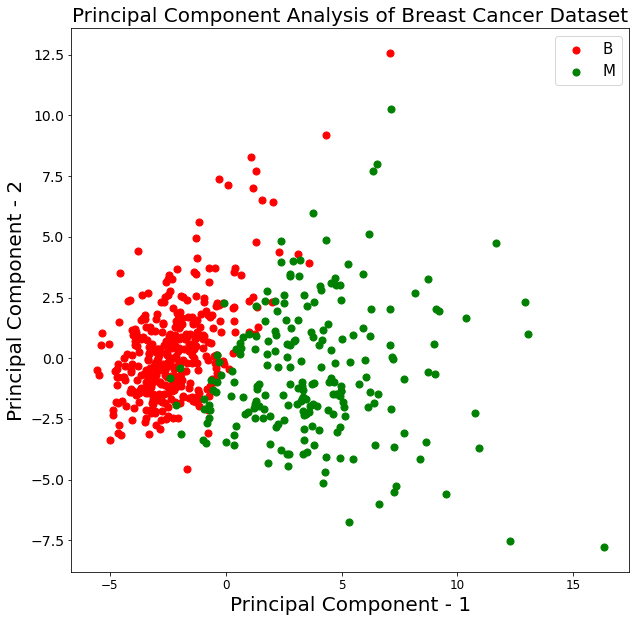

In [10]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['B', 'M']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = dataset['diagnosis'] == target
    plt.scatter(pd.DataFrame(principalComponents_breast).loc[indicesToKeep, 0]
               , pd.DataFrame(principalComponents_breast).loc[indicesToKeep, 1], c = color, s = 50)

plt.legend(targets,prop={'size': 15});


There is a clear separation of diagnosis (M or B) that is evident in the PC1 vs PC2 plot.

Once you have the principal components, you can find the explained_variance_ratio. It will provide you with the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

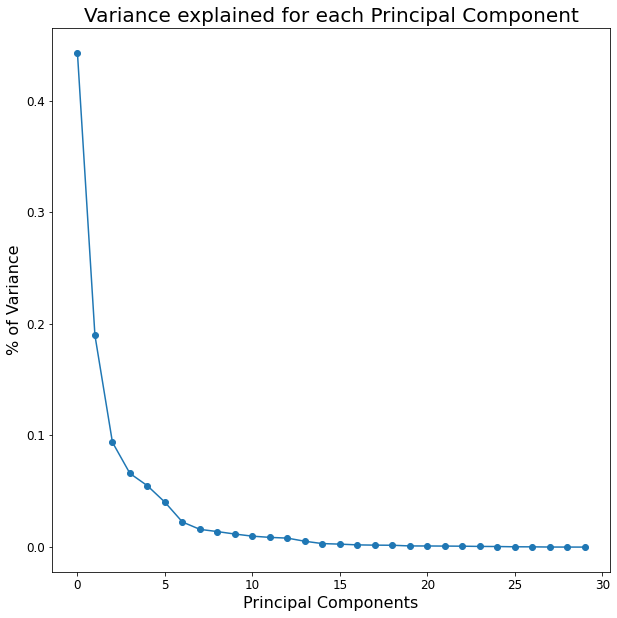

In [11]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Variance explained for each Principal Component", fontsize=20)
plt.plot(pca_breast.explained_variance_ratio_, 'o-')
plt.xlabel("Principal Components", fontsize=16)
plt.ylabel("% of Variance", fontsize=16);

Let's see the cumulative variance of the PC to understand how many of them i might need

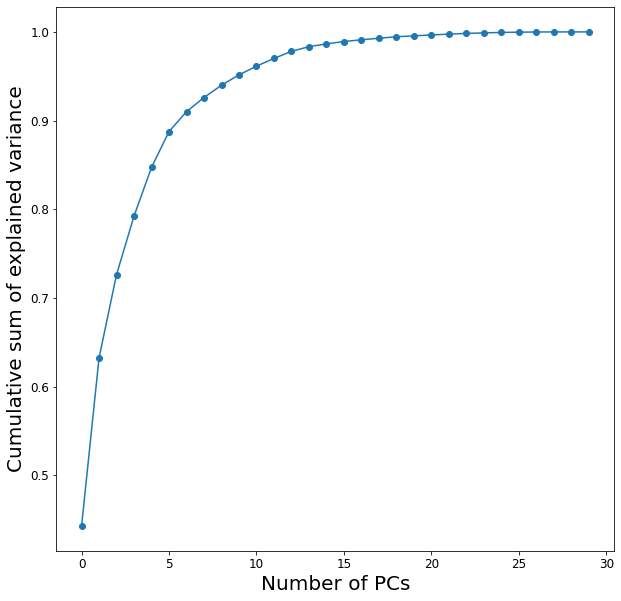

In [12]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.cumsum(pca_breast.explained_variance_ratio_), '-o')
plt.xlabel('Number of PCs', fontsize=20)
plt.ylabel('Cumulative sum of explained variance' , fontsize=20);

89% of the variation is explained by the first six PC’s. Therefore, for the latter model generation we will use only these six principal components

## Principal Component Selection

Based on the Cumulative Proportion of Variance Explained, decide how many principal components you want to select (i.e., you should choose a small number of PC that can explain most of the variance).

Extract the N-principal components (being N the number of coefficients that you have decided). 

In [13]:
dataset_pca = pd.concat([pd.DataFrame(principalComponents_breast).iloc[:, 0:6], dataset.diagnosis], axis=1)
dataset_pca.columns = ["PC1","PC2","PC3","PC4","PC5","PC6","diagnosis"]
dataset_pca.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,diagnosis
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,M
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,M
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,M
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,M
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,M


By means of PCA we have transformed the original dataset with more than 30 dimensions to only six principal components. We will now apply a predictive model based on LDA.

# Linear Discriminant Analysis (LDA)

From the principal component’s scatter plots it is evident that there is some clustering of benign and malignant points. This suggests that we could build a linear discriminant function using these principal components. 

## Model building and validation

In [24]:
X = dataset_pca.iloc[:, 0:6]
y = dataset_pca.diagnosis

Calculate the linear discriminant function by using the `LinearDiscriminantAnalysis` function of the `sklearn` package: (https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)


In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
print("Accuracy of the PCA-based LDA classifier = {0:.4f}".format(np.mean(cross_val_score(lda_clf, X, y))))

Accuracy of the PCA-based LDA classifier = 0.9473


We have achieved a great accuracy score! As discussed in class, when you can transform the data so you can create a linear classifier, LDA is an almost perfect classifier

## Model Comparison

Compare the PCA-based model to a model including all the features.

In [28]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())])

X = original_dataset.iloc[:, 2:32]
y = original_dataset.diagnosis

print("Accuracy of the full dataset LDA classifier = {0:.4f}".format(np.mean(cross_val_score(pipeline, X, y))))

Accuracy of the full dataset LDA classifier = 0.9596


The LDA classifier over the entire dataset is slightly better (not by far). But, the most interesting aspect rather than the small difference in performance is the size of the dataset. By applying PCA we have removed the original number of dimensions from 30 to 6 (you can further experiment by selecting a different number of Principal Components). As discussed many times in class, by reducing the dimensionality of the dataset we will reduce the risk of overfitting, as well as the complexity of our algorithm.

# Everything Together

Let's use the pipeline to wrap everything together and to find the best configuration for the different hyper-parameters


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('LDA', LinearDiscriminantAnalysis())]) # Pipeline the entire process: Scale the data -> PCA -> LDA Classifier

n_components = list(range(1,30)) # We will try different numbers of principal components

#Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {"pca__n_components":n_components}

estimator = GridSearchCV(pipeline, param_grid, cv=5) # Create a grid search to try all the possible number of PCs
estimator.fit(X, y);

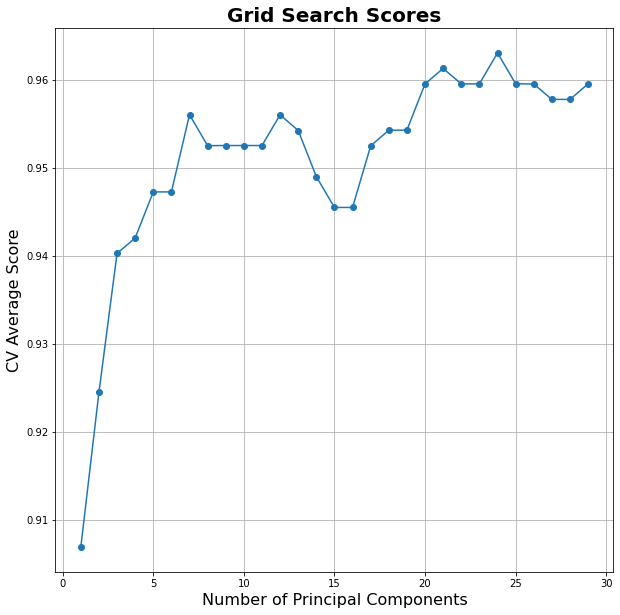

In [30]:
# Get Test Scores Mean and std for each grid search
scores_mean = estimator.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean)

scores_sd = estimator.cv_results_['std_test_score']
scores_sd = np.array(scores_sd)

# Plot Grid search scores
plt.figure(figsize=(10,10))
plt.plot(n_components, scores_mean, '-o')

plt.title("Grid Search Scores", fontsize=20, fontweight='bold')
plt.xlabel("Number of Principal Components", fontsize=16)
plt.ylabel('CV Average Score', fontsize=16)
plt.grid('on')


As can be seen in the graph, the optimal number of PCs to select will be 24, achieving a performance of more than 96% of accuracy.

# Bonus Track: LDA for Multiclass Classification

Let's apply LDA to a more challenging scenario: recognize handwritten digits. This is a now classical example since most of the introductory Deep Learning tutorials use it. However, I will prove you that a simpler LDA classifier is able to do the job. 
**Examples and plots taken from: https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b**



sklearn includes the a dataset of [handwritten digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) that we will use for the experimentation. Let's load it and take a look at the digits.

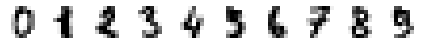

In [31]:
from sklearn import datasets, svm, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.tight_layout()
    

The images are just 8x8 pixels but they contain enough information to recognize the digits

Let's split the dataset and train an LDA classifier

In [32]:
from sklearn.model_selection import train_test_split

X = digits.data
y = digits.target
target_names = digits.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

# Create a classifier: a Fisher's LDA classifier
lda = LinearDiscriminantAnalysis(n_components=4, solver='eigen', shrinkage=0.1)

# Train lda on the first half of the digits
lda = lda.fit(X_train, y_train)

Once trained, we can actually take a look at the representation of the original dataset in the new dimensionality that LDA generates

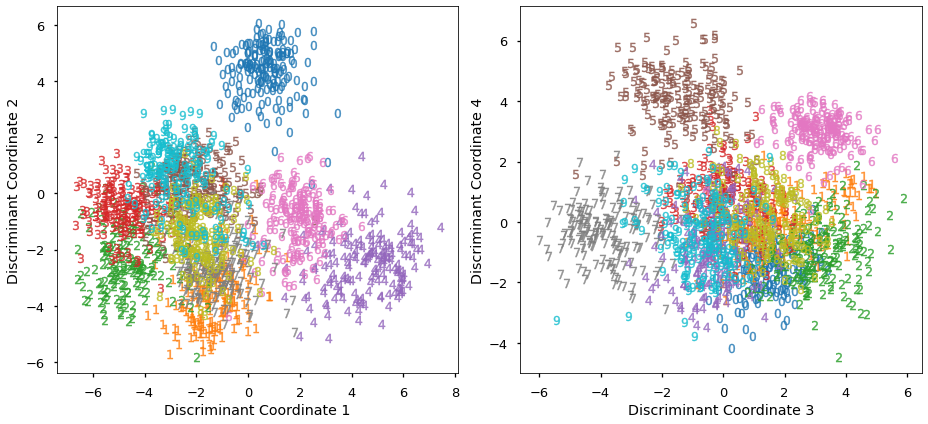

In [33]:
# Transform the original dataset to the dimensionality generated by LDA
X_r_lda = lda.transform(X)

# Visualize transformed data on learnt discriminant coordinates
with plt.style.context('seaborn-talk'):
    fig, axes = plt.subplots(1,2,figsize=[13,6])
    for i, target_name in zip([0,1,2,3,4,5,6,7,8,9], target_names):
        axes[0].scatter(X_r_lda[y == i, 0], X_r_lda[y == i, 1], alpha=.8,
                        label=target_name, marker='$%.f$'%i)
        axes[1].scatter(X_r_lda[y == i, 2], X_r_lda[y == i, 3], alpha=.8,
                        label=target_name, marker='$%.f$'%i)
    axes[0].set_xlabel('Discriminant Coordinate 1')
    axes[0].set_ylabel('Discriminant Coordinate 2')
    axes[1].set_xlabel('Discriminant Coordinate 3')
    axes[1].set_ylabel('Discriminant Coordinate 4')
    plt.tight_layout()

As you can see, numbers are pretty well separated according to the LDA coordinates. Remember that this is exactly what LDA is expected to do: generate the representation of the data where the classes are better separated.
Based on that, we can expect a great performance, let's check it

In [34]:
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

print("Accuracy = {0:.4f}\n".format(accuracy_score(lda.predict(X_test), y_test)))
print("Classification Report")
print(classification_report(lda.predict(X_test), y_test))

Accuracy = 0.9644

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.90      0.96      0.93        46
           2       1.00      0.98      0.99        45
           3       0.98      1.00      0.99        46
           4       1.00      1.00      1.00        39
           5       0.96      1.00      0.98        51
           6       1.00      0.98      0.99        47
           7       0.97      0.95      0.96        40
           8       0.87      0.89      0.88        37
           9       0.96      0.88      0.91        49

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.97      0.96      0.96       450



As expected, we achieve a great accuracy. Moreover, by inspecting the classification report we can see that LDA performs great on recognizing most of the digits. The main problem it has is on recognizing 8s, 9s and 1s. If we inspect the confusion matrix, we can see that this is because LDA is confusing them (i.e., they look kind of similar in the dataset).

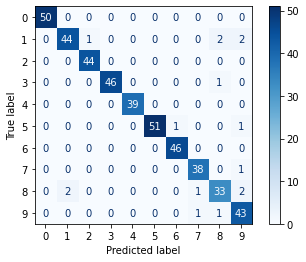

In [35]:
plot_confusion_matrix(lda, X_test, y_test,cmap=plt.cm.Blues, labels=target_names);